In [1]:
import sys, os, math
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import importlib

import torch.nn as nn
from torch.functional import F
import torch.distributions as dist
from torch.utils.data import DataLoader, TensorDataset, random_split

sys.path.append('../')
from utils_modules.models import Expander, vector_to_Cov
from utils_modules.vicreg import vicreg_loss
import utils_modules.data as utils_data
import utils_modules.baryons_toy_Pk as utils_toy_Pk
from scipy import stats

/n/home11/aakhmetzhanova/.conda/envs/simclr_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# plot formatting 
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)

rcnew = {"mathtext.fontset" : "cm", 
         "text.usetex": False,
         
         'figure.frameon': True,
         'axes.linewidth': 2.,
         
         "axes.titlesize" : 32, 
         "axes.labelsize" : 28,
         "legend.fontsize" : 28,
         'legend.fancybox': True,
         'lines.linewidth': 2.5,
         
         'xtick.alignment': 'center',
          'xtick.bottom': True,
          'xtick.color': 'black',
          'xtick.direction': 'in',
          'xtick.labelbottom': True,
          'xtick.labelsize': 24, #17.5,
          'xtick.labeltop': False,
          'xtick.major.bottom': True,
          'xtick.major.pad': 6.0,
          'xtick.major.size': 14.0,
          'xtick.major.top': True,
          'xtick.major.width': 1.5,
          'xtick.minor.bottom': True,
          'xtick.minor.pad': 3.4,
          'xtick.minor.size': 7.0,
          'xtick.minor.top': True,
          'xtick.minor.visible': True,
          'xtick.minor.width': 1.0,
          'xtick.top': True,
         
          'ytick.alignment': 'center_baseline',
          'ytick.color': 'black',
          'ytick.direction': 'in',
          'ytick.labelleft': True,
          'ytick.labelright': False,
          'ytick.labelsize': 24, 
          'ytick.left': True,
          'ytick.major.left': True,
          'ytick.major.pad': 6.0,
          'ytick.major.right': True,
          'ytick.major.size': 14.0,
          'ytick.major.width': 1.5,
          'ytick.minor.left': True,
          'ytick.minor.pad': 3.4,
          'ytick.minor.right': True,
          'ytick.minor.size': 7.0,
          'ytick.minor.visible': True,
          'ytick.minor.width': 1.0,
          'ytick.right': True
         
        }
plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')

%config InlineBackend.figure_format = 'retina'


In [20]:
# select device; use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: %s'%(device))

Device: cuda


## Generate parameters

In [4]:
kmin  = 7e-3 #h/Mpc
kmax = 1

kF     = kmin
k_bins = int((kmax-kmin)/kF)
k      = np.arange(3,k_bins+2)*kF 
Nk     = 4.0*np.pi*k**2*kF/kF**3  #number of modes in each k-bin

# model parameters
predict_D     = True
Pk_continuous = True #whether fix A_value for kpivot or not

dset_size = 1000
train_frac, valid_frac, test_frac = 0.8, 0.1, 0.1

seed = 17
splits = 1

plot=True
verbose=True

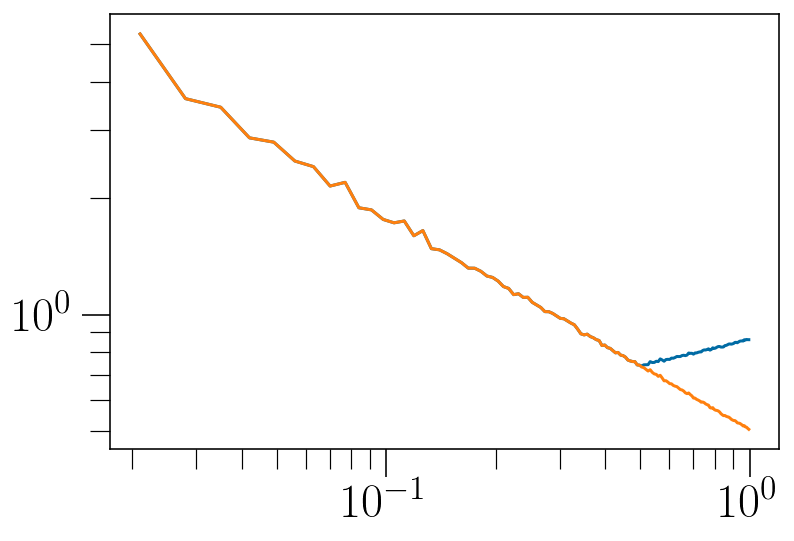

In [5]:
params = utils_toy_Pk.generate_params(dset_size, splits, 
                                      predict_D = predict_D, 
                                      Pk_continuous = Pk_continuous,
                                      seed = seed)
params = params.reshape(dset_size, splits, -1)

Pk_BPL = utils_toy_Pk.get_Pk_arr(k, Nk, params, predict_D = True, seed = seed)
Pk_cont = utils_toy_Pk.get_Pk_arr(k, Nk, params, predict_D = False, seed = seed)

for i in range(splits):
    plt.loglog(k, Pk_BPL[108, i, :])
    plt.loglog(k, Pk_cont[108, i, :])

### Load models

In [6]:
# define the encoder model
hidden = 16
last_layer = 32
args_net = [hidden, 
            last_layer, last_layer, last_layer, 
            last_layer, last_layer, last_layer]

In [21]:
inv, var, cov = 15, 15, 1
fmodel = 'trained_models/VICReg_{:d}_{:d}_{:d}.pt'.format(inv, var, cov)
fout   = 'trained_models/VICReg_{:d}_{:d}_{:d}.txt'.format(inv, var, cov)


net = Expander(args_net, k.shape[0], bn = True).to(device)
net.load_state_dict(torch.load(fmodel))
net.eval(); 



In [22]:
inv, var, cov = 15, 15, 1
fmodel = 'trained_models/VICReg_cosmic_var_{:d}_{:d}_{:d}.pt'.format(inv, var, cov)
fout   = 'trained_models/VICReg_cosmic_var_{:d}_{:d}_{:d}.txt'.format(inv, var, cov)

net_cv = Expander(args_net, k.shape[0], bn = True).to(device)
net_cv.load_state_dict(torch.load(fmodel))
net_cv.eval(); 


## (1) Compute distance covariance metric

In [24]:
# the code to compute distance covariance metric is from 
# https://gist.github.com/kailashbuki/7ea6467d2e0156ef6002a06d7dd4cf82
from scipy.spatial.distance import pdist, squareform

def dcov(X, Y):
    """Computes the distance covariance between matrices X and Y.
    """
    n = X.shape[0]
    XY = np.multiply(X, Y)
    cov = np.sqrt(XY.sum()) / n
    return cov


def dvar(X):
    """Computes the distance variance of a matrix X.
    """
    return np.sqrt(np.sum(X ** 2 / X.shape[0] ** 2))


def cent_dist(X):
    """Computes the pairwise euclidean distance between rows of X and centers
     each cell of the distance matrix with row mean, column mean, and grand mean.
    """
    M = squareform(pdist(X))    # distance matrix
    rmean = M.mean(axis=1)
    cmean = M.mean(axis=0)
    gmean = rmean.mean()
    R = np.tile(rmean, (M.shape[0], 1)).transpose()
    C = np.tile(cmean, (M.shape[1], 1))
    G = np.tile(gmean, M.shape)
    CM = M - R - C + G
    return CM


def dcor(X, Y):
    """Computes the distance correlation between two matrices X and Y.
    X and Y must have the same number of rows.
    >>> X = np.matrix('1;2;3;4;5')
    >>> Y = np.matrix('1;2;9;4;4')
    >>> dcor(X, Y)
    0.76267624241686649
    """
    assert X.shape[0] == Y.shape[0]

    A = cent_dist(X)
    B = cent_dist(Y)

    dcov_AB = dcov(A, B)
    dvar_A = dvar(A)
    dvar_B = dvar(B)

    dcor = 0.0
    if dvar_A > 0.0 and dvar_B > 0.0:
        dcor = dcov_AB / np.sqrt(dvar_A * dvar_B)

    return dcor

In [12]:
def get_dist_corrs_k(embedds, Pk):
    dist_corrs = []
    embedds_0 = embedds.cpu().detach().numpy()
    for i in range(Pk.shape[-1]):
        corrs = []
        
        Pk_Temp = Pk[:, i]
        dist_corrs.append(dcor(embedds_0, Pk_Temp[:, None]))

    dist_corrs = torch.tensor(dist_corrs)
    return dist_corrs

In [11]:
log_Pk_BPL = np.log(Pk_BPL).reshape(-1, len(k))
net.eval()
embedds_BPL = net(torch.tensor(log_Pk_BPL).float().to(device))

net_cv.eval()
embedds_cv_BPL = net_cv(torch.tensor(log_Pk_BPL).float().to(device))

embedds_arr_BPL = [embedds_BPL, embedds_cv_BPL]

labels_BPL = ['BPL with varying D', 'BPL with constant D']
markers_BPL = ['*', 'o']
colors_BPL = ['coral', 'forestgreen']

In [13]:
arr_dist_corrs = []
arr_dist_corrs.append(get_dist_corrs_k(embedds_arr_BPL[0], 
                                       log_Pk_BPL))
arr_dist_corrs.append(get_dist_corrs_k(embedds_arr_BPL[1], 
                                       log_Pk_BPL))

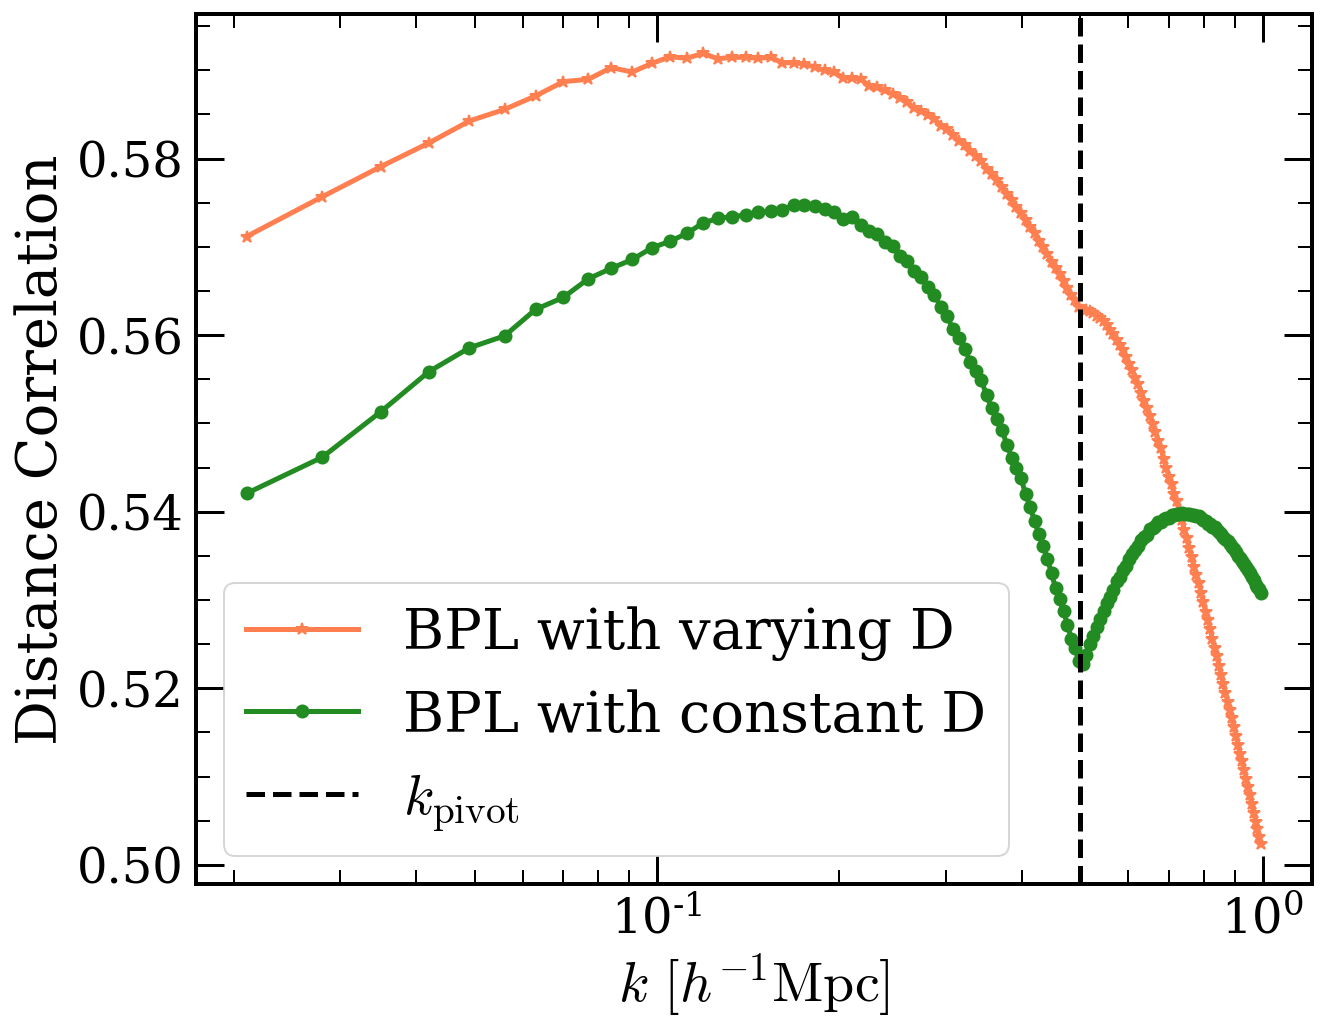

In [15]:
#################
plt.figure(1, figsize = (10, 8))
plt.xscale('log')
plt.xlabel(r'$k \, \, [h^{-1} \mathrm{Mpc}]$')
plt.ylabel('Distance Correlation')
for i, arr in enumerate(arr_dist_corrs):
    plt.plot(k, arr,
                marker = markers_BPL[i], label = labels_BPL[i], c = colors_BPL[i])
plt.axvline(0.5, label = r'$k_{\mathrm{pivot}}$', c = 'k', ls = '--')
plt.legend(loc = 'best')


## MI

In [28]:
MI_vicreg = np.load('MI_results/MI_D_varies_BPL.npy')
MI_vicreg_cosmic_var = np.load('MI_results/MI_D_constant_BPL.npy')

In [29]:
MI_estimates_cosmic_var = []
MI_estimates = []
for i in range(k.shape[0]):
    MI = MI_vicreg[i, :]
    MI_estimates.append(np.max(MI[~np.isnan(MI)]))
    
    MI_cv = MI_vicreg_cosmic_var[i, :]
    MI_estimates_cosmic_var.append(np.max(MI_cv[~np.isnan(MI_cv)]))

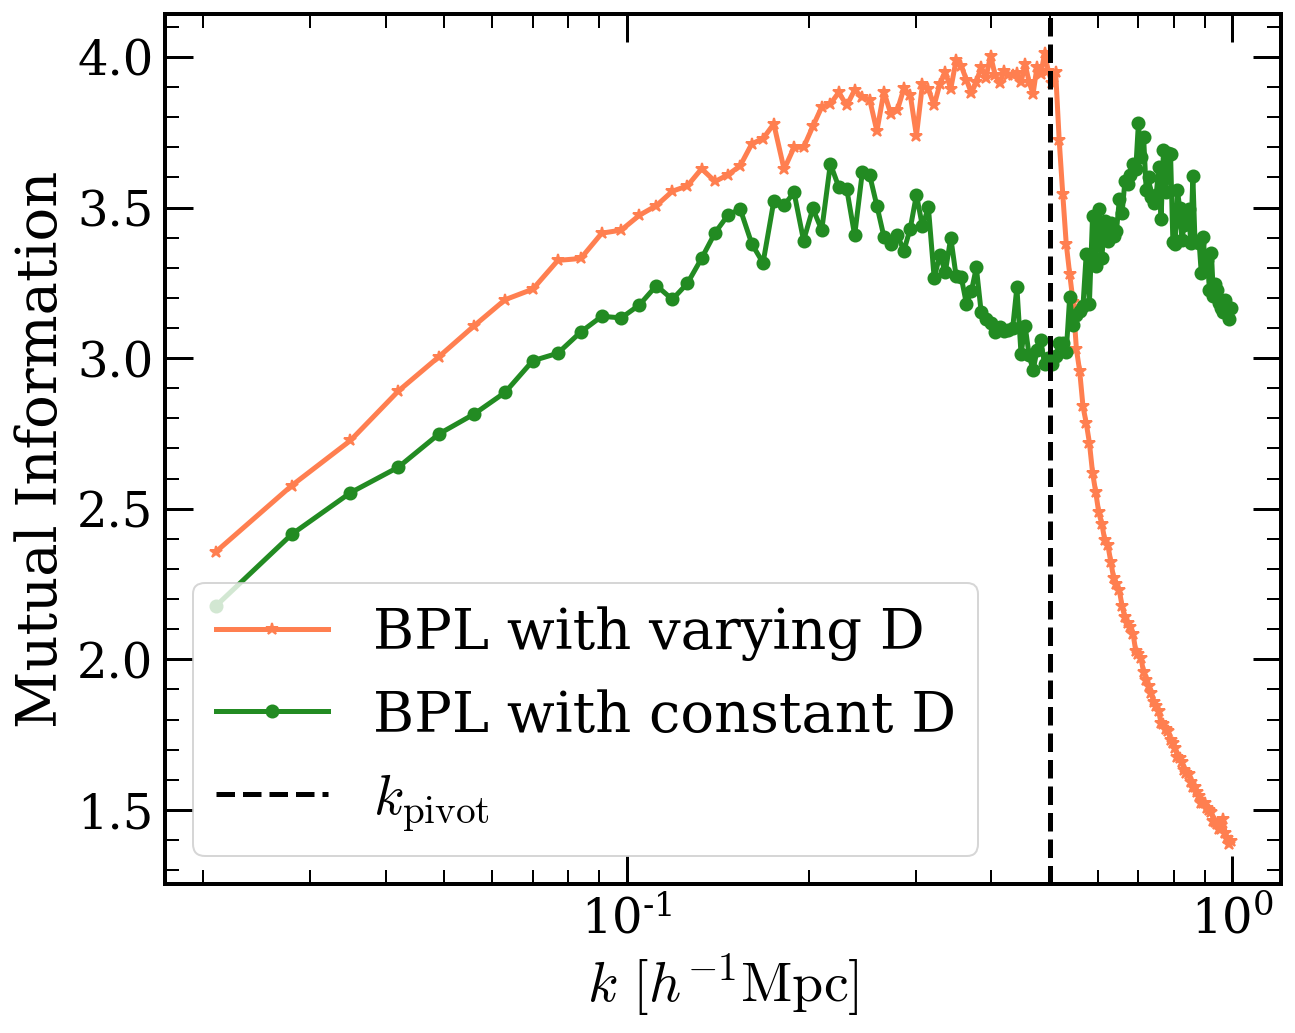

In [30]:
plt.figure(1, figsize = (10, 8))
plt.xscale('log')
plt.xlabel(r'$k \, \, [h^{-1} \mathrm{Mpc}]$')
plt.ylabel('Mutual Information')

plt.plot(k, MI_estimates,
         label ='BPL with varying D', c = colors_BPL[0], marker = markers_BPL[0],) 
plt.plot(k, MI_estimates_cosmic_var,
         label = 'BPL with constant D', c = colors_BPL[1],marker = markers_BPL[1],) 

plt.axvline(0.5, label = r'$k_{\mathrm{pivot}}$', c = 'k', ls = '--')
plt.legend(loc = 'lower left')

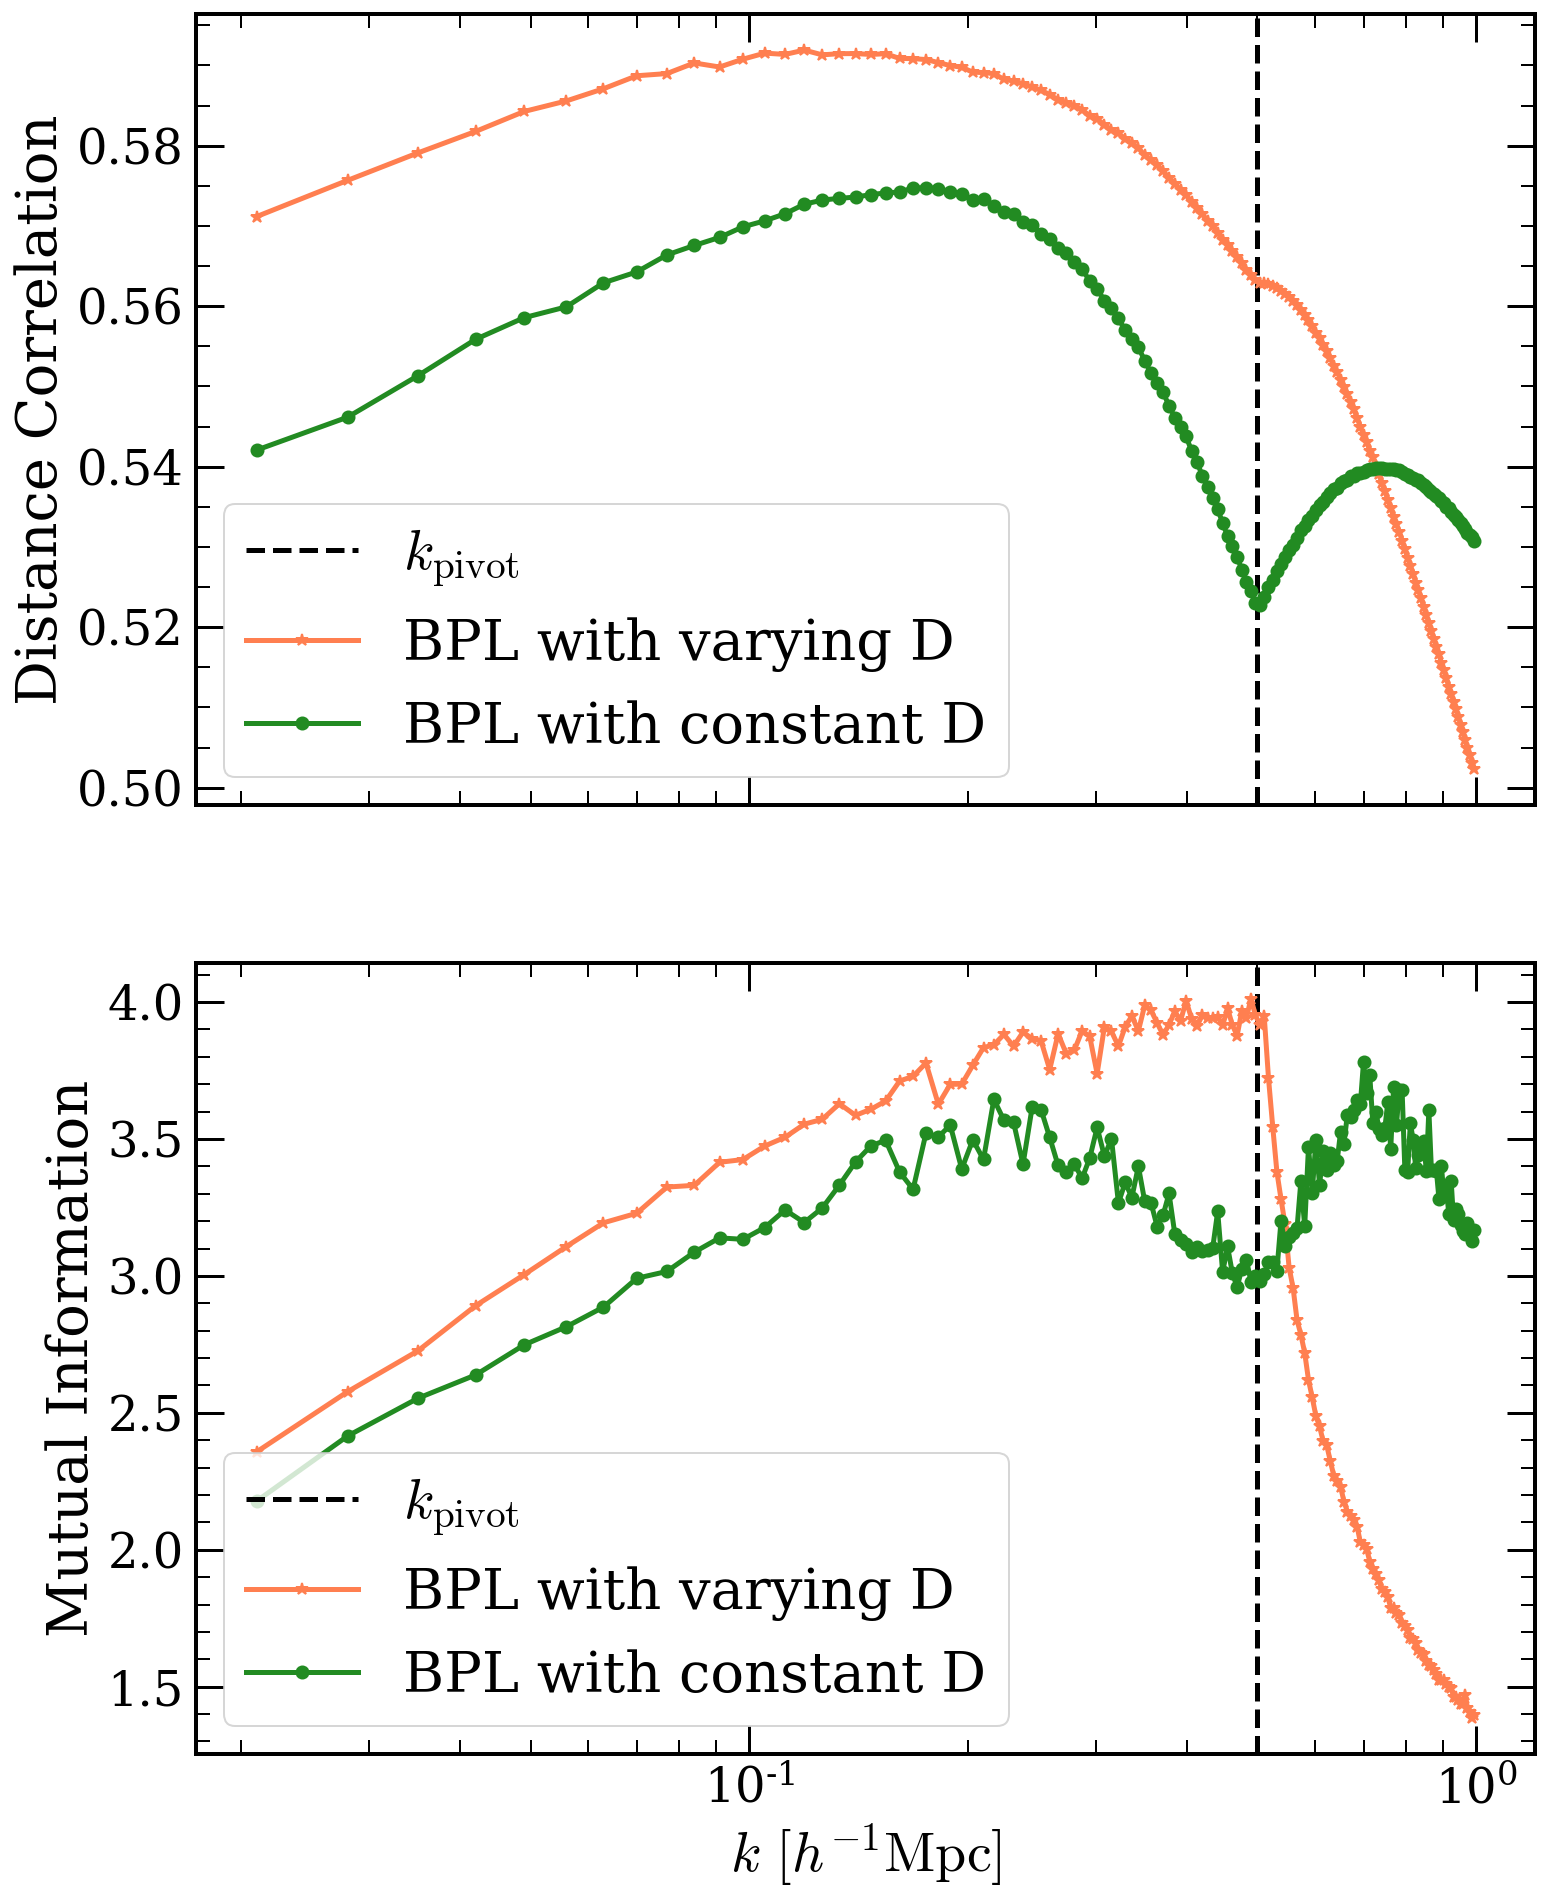

In [31]:
fig, axs = plt.subplots(2, 1, figsize = (12, 16), sharex=True)

axs[0].set_ylabel('Distance Correlation')
axs[0].axvline(0.5, label = r'$k_{\mathrm{pivot}}$', c = 'k', ls = '--')

for i, arr in enumerate(arr_dist_corrs):
    axs[0].plot(k, arr, label = labels_BPL[i],c=colors_BPL[i], marker = markers_BPL[i],)
axs[0].legend(loc = 'lower left')

axs[1].axvline(0.5, label = r'$k_{\mathrm{pivot}}$', c = 'k', ls = '--')
axs[1].set_xscale('log')
axs[1].set_ylabel('Mutual Information')
axs[1].set_xlabel(r'$k \, \, [h^{-1} \mathrm{Mpc}]$')
axs[1].plot(k, MI_estimates, label ='BPL with varying D', 
            c=colors_BPL[0], marker = markers_BPL[0],)
axs[1].plot(k, MI_estimates_cosmic_var, label = 'BPL with constant D', 
            c=colors_BPL[1], marker = markers_BPL[1],)
axs[1].legend(loc = 'lower left')